In [1]:
%load_ext autoreload
% autoreload 2

UsageError: Line magic function `%` not found.


In [2]:
import numpy as np
from matplotlib import pyplot as plt
plt.style.use(['paper.mplstyle'])

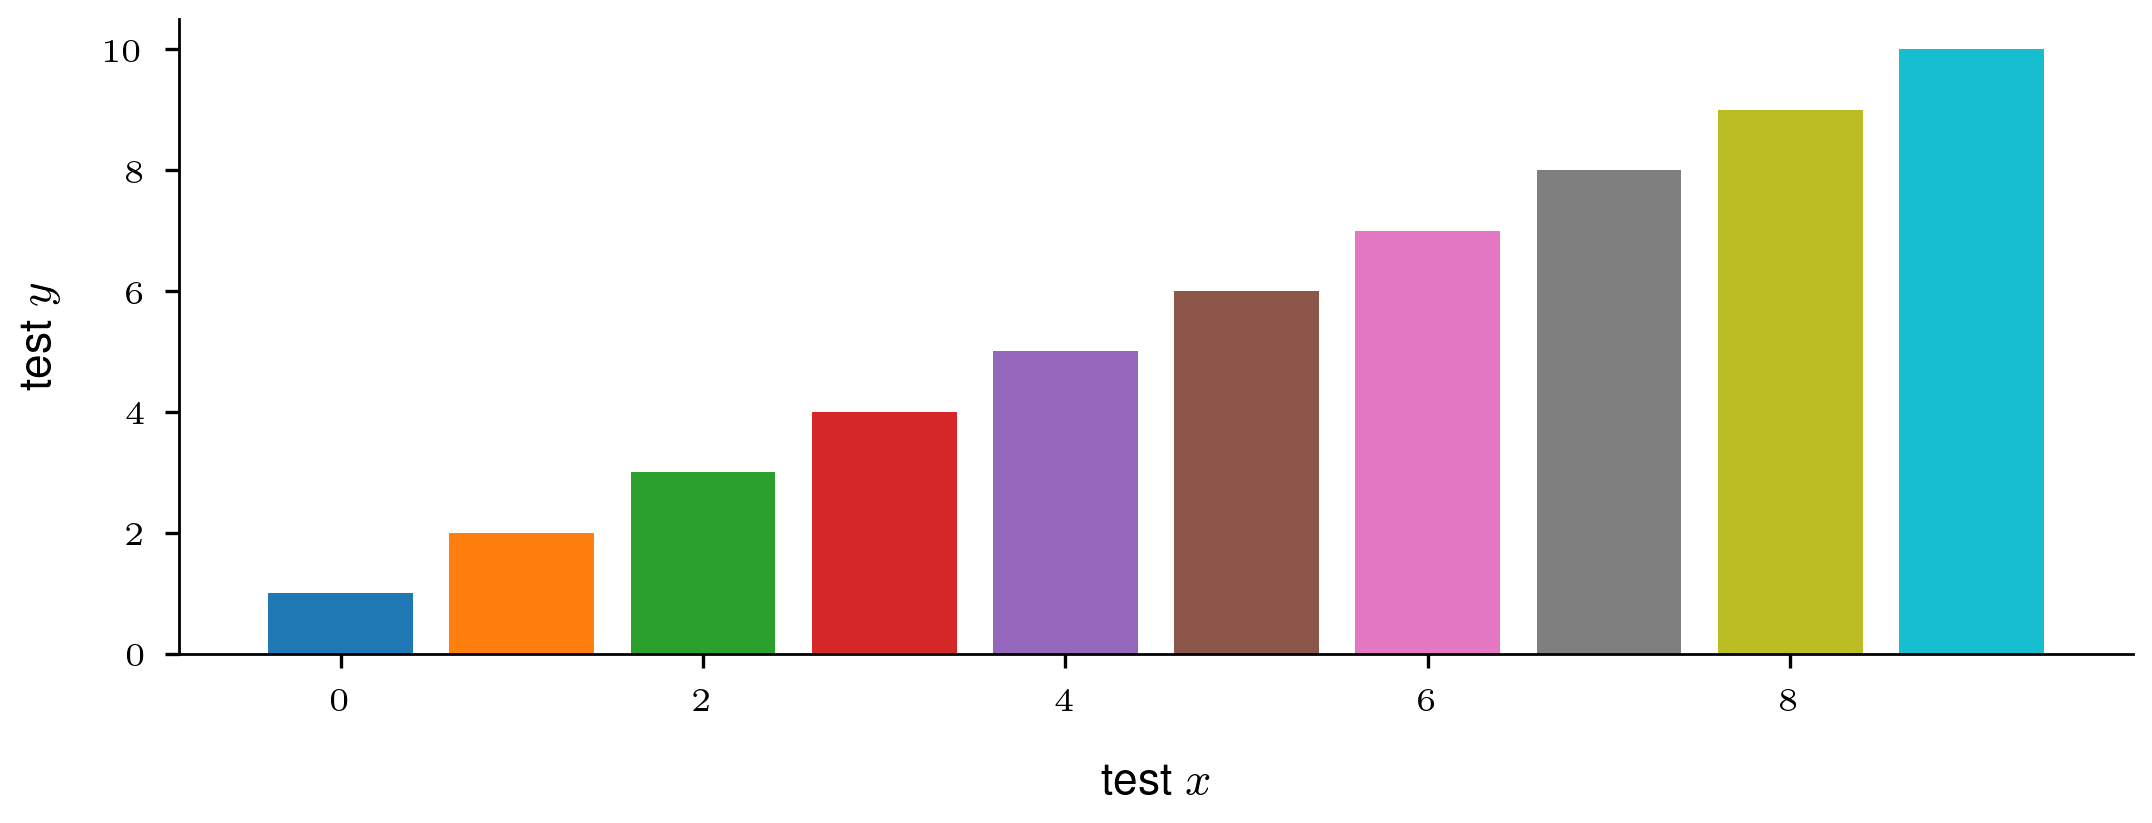

In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
import matplotlib.lines as mlines

text_width = 6.30107 # in  --> Confirmed with template explanation

fs_m1 = 6  # for figure ticks
fs = 8  # for regular figure text
fs_p1 = 9  # figure titles

matplotlib.rc('font', size=fs)          # controls default text sizes
matplotlib.rc('axes', titlesize=fs)     # fontsize of the axes title
matplotlib.rc('axes', labelsize=fs)    # fontsize of the x and y labels
matplotlib.rc('xtick', labelsize=fs_m1)    # fontsize of the tick labels
matplotlib.rc('ytick', labelsize=fs_m1)    # fontsize of the tick labels
matplotlib.rc('legend', fontsize=fs_m1)    # legend fontsize
matplotlib.rc('figure', titlesize=fs_p1)  # fontsize of the figure title


matplotlib.rc('font', **{'family':'sans-serif', 'sans-serif': ['Helvetica']})
matplotlib.rc('text', usetex=True)

plt.figure(dpi=400, figsize=(text_width, text_width/3))
for i in range(10):
       plt.bar(i, i + 1, color=f'C{i}', zorder=2)
       # ^ This zorder nonsense makes the grid  lines go behid the bars. I don't know why this is needed for barplots, but shouldn't usually be needed.
# plt.title('\\textbf{Test}, $\\mathcal{C}, \\mathbb{R}$')
plt.xlabel('test $x$')
plt.ylabel('test $y$')
plt.show()

***FIGURE 2***


In [25]:
seed = 1
dir = f"/home/mmcs3/rds/rds-t2-cs156-T7o4pEA8QoU/mmcs3/random_monkeys_random_lambda_1E-6/ramping/seed_1_400_1"
targets = np.loadtxt(f"/home/mmcs3/rds/rds-t2-cs156-T7o4pEA8QoU/mmcs3/random_monkeys_random_lambda_2E-6/ramping_skew/seed_3_200_2_1._0.025/targets")
print(dir)

/home/mmcs3/rds/rds-t2-cs156-T7o4pEA8QoU/mmcs3/random_monkeys_random_lambda_1E-6/ramping/seed_1_400_1


In [34]:
#analyses : computation of the prep idx 
import numpy as np
n_targets = 2
movs = [0,0]
times = [0, 50, 100, 300, 500]


def rates(t, i = 0):
    return np.loadtxt(f'{dir}/rates_{i}_{t}')

def us(t, i = 0):
    return np.loadtxt(f'{dir}/us_{i}_{t}')

def torques(t, i = 0):
    return np.loadtxt(f'{dir}/torques_{i}_{t}')

def mov(t, i = 0):
    return np.loadtxt(f'{dir}/thetas_{i}_{t}')


def prep_idx():
    def get_prep_idx(us, t):
        if t == 0:
            return 0
        else : 
            cutoff = int(t/2 )
            u_prep, u_mov = us[:cutoff-1], us[cutoff-1:]
            return np.sum(u_prep**2)/np.sum(u_mov**2)
    def get_all_idces(i):
        ai = np.asarray([get_prep_idx(us(t, i),t) for t in times])
        return ai
    idces = np.concatenate([get_all_idces(i)[:,None] for i in movs], axis=1)
    m, v = np.mean(idces, axis=1), np.std(idces, axis=1)/np.sqrt(8)
    return m, v

def cost_u():
    def cost_u(t, i):
       return np.loadtxt(f'{dir}/u_cost_{i}_{t}')[-1]
    def get_all_idces(i):
        ai = np.asarray([cost_u(t,i) for t in times])
        return ai
    idces = np.concatenate([get_all_idces(i)[:,None] for i in movs], axis=1)
    m, v = np.mean(idces, axis=1), np.std(idces, axis=1)/np.sqrt(8)
    return m, v

def cost_tgt():
    def cost_tgt(t, i):
       return np.loadtxt(f'{dir}/task_cost_{i}_{t}')[-1]
    def get_all_idces(i):
        ai = np.asarray([cost_tgt(t,i) for t in times])
        return ai
    idces = np.concatenate([get_all_idces(i)[:,None] for i in movs], axis=1)
    m, v = np.mean(idces, axis=1), np.std(idces, axis=1)/np.sqrt(n_targets)
    return m, v

def cost_torques():
    def cost_torques(t, i):
       return np.loadtxt(f'{dir}/task_cost_{i}_{t}')[0]
    def get_all_idces(i):
        ai = np.asarray([cost_torques(t,i) for t in times])
        return ai
    idces = np.concatenate([get_all_idces(i)[:,None] for i in movs], axis=1)
    m, v = np.mean(idces, axis=1), np.std(idces, axis=1)/np.sqrt(n_targets)
    return m, v

def mv_loss():
    def cost_torques(t, i):
       return np.loadtxt(f'{dir}/loss_{i}_{t}').sum()
    def get_all_idces(i):
        ai = np.asarray([cost_torques(t,i) for t in times])
        return ai
    idces = np.concatenate([get_all_idces(i)[:,None] for i in movs], axis=1)
    m, v = np.mean(idces, axis=1), np.std(idces, axis=1)/np.sqrt(n_targets)
    return m, v

def reaction_time():
    def get_mov_time(mov, t):
        vel = np.sqrt(mov[:,2]**2 + mov[:,3]**2)
        threshold = 0.1* np.max(vel)
        idces = np.argwhere(vel > threshold)
        min_idx = np.min(idces)
        return min_idx * 0.002 - t*0.001
    def get_all_idces(i):
        ai = np.asarray([get_mov_time(mov(t, i),t) for t in times])
        return ai
    idces = np.concatenate([get_all_idces(i)[:,None] for i in movs], axis=1)
    m, v = np.mean(idces, axis=1), np.std(idces, axis=1)/np.sqrt(n_targets)
    return m, v
    
def successful_reach():
    def get_mov_time(mov, tgt):
        end_pos = mov[-100:,:2]
        end_diff = np.linalg.norm(end_pos - tgt[:2], axis=1)
        failures = np.sum(np.where(end_diff> 0.1, 1., 0.))
        print(failures)
        return failures
    def get_all_idces(i):
        tgt = targets[i]
        ai = np.asarray([get_mov_time(mov(t, i), tgt) for t in times])
        return ai
    idces = np.concatenate([get_all_idces(i)[:,None] for i in movs], axis=1)
    m, v = np.mean(idces, axis=1), np.std(idces, axis=1)/np.sqrt(n_targets)
    return m, v

def proj_prep(i):
    return np.loadtxt(f"{dir}/pca/proj_reach_prep_{i}_300")
m_prep, v_prep = prep_idx()
m_cost_u, v_cost_u = cost_u()
m_cost_torques, v_cost_torques = cost_torques()
m_cost_tgt, v_cost_tgt = cost_tgt()
m_loss, v_loss = mv_loss()
m_reac, v_reac = reaction_time()

sr = successful_reach()

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


FileNotFoundError: /home/mmcs3/rds/rds-t2-cs156-T7o4pEA8QoU/mmcs3/random_monkeys_random_lambda_1E-6/ramping/seed_1_400_1/pca/proj_reach_prep_0_300 not found.

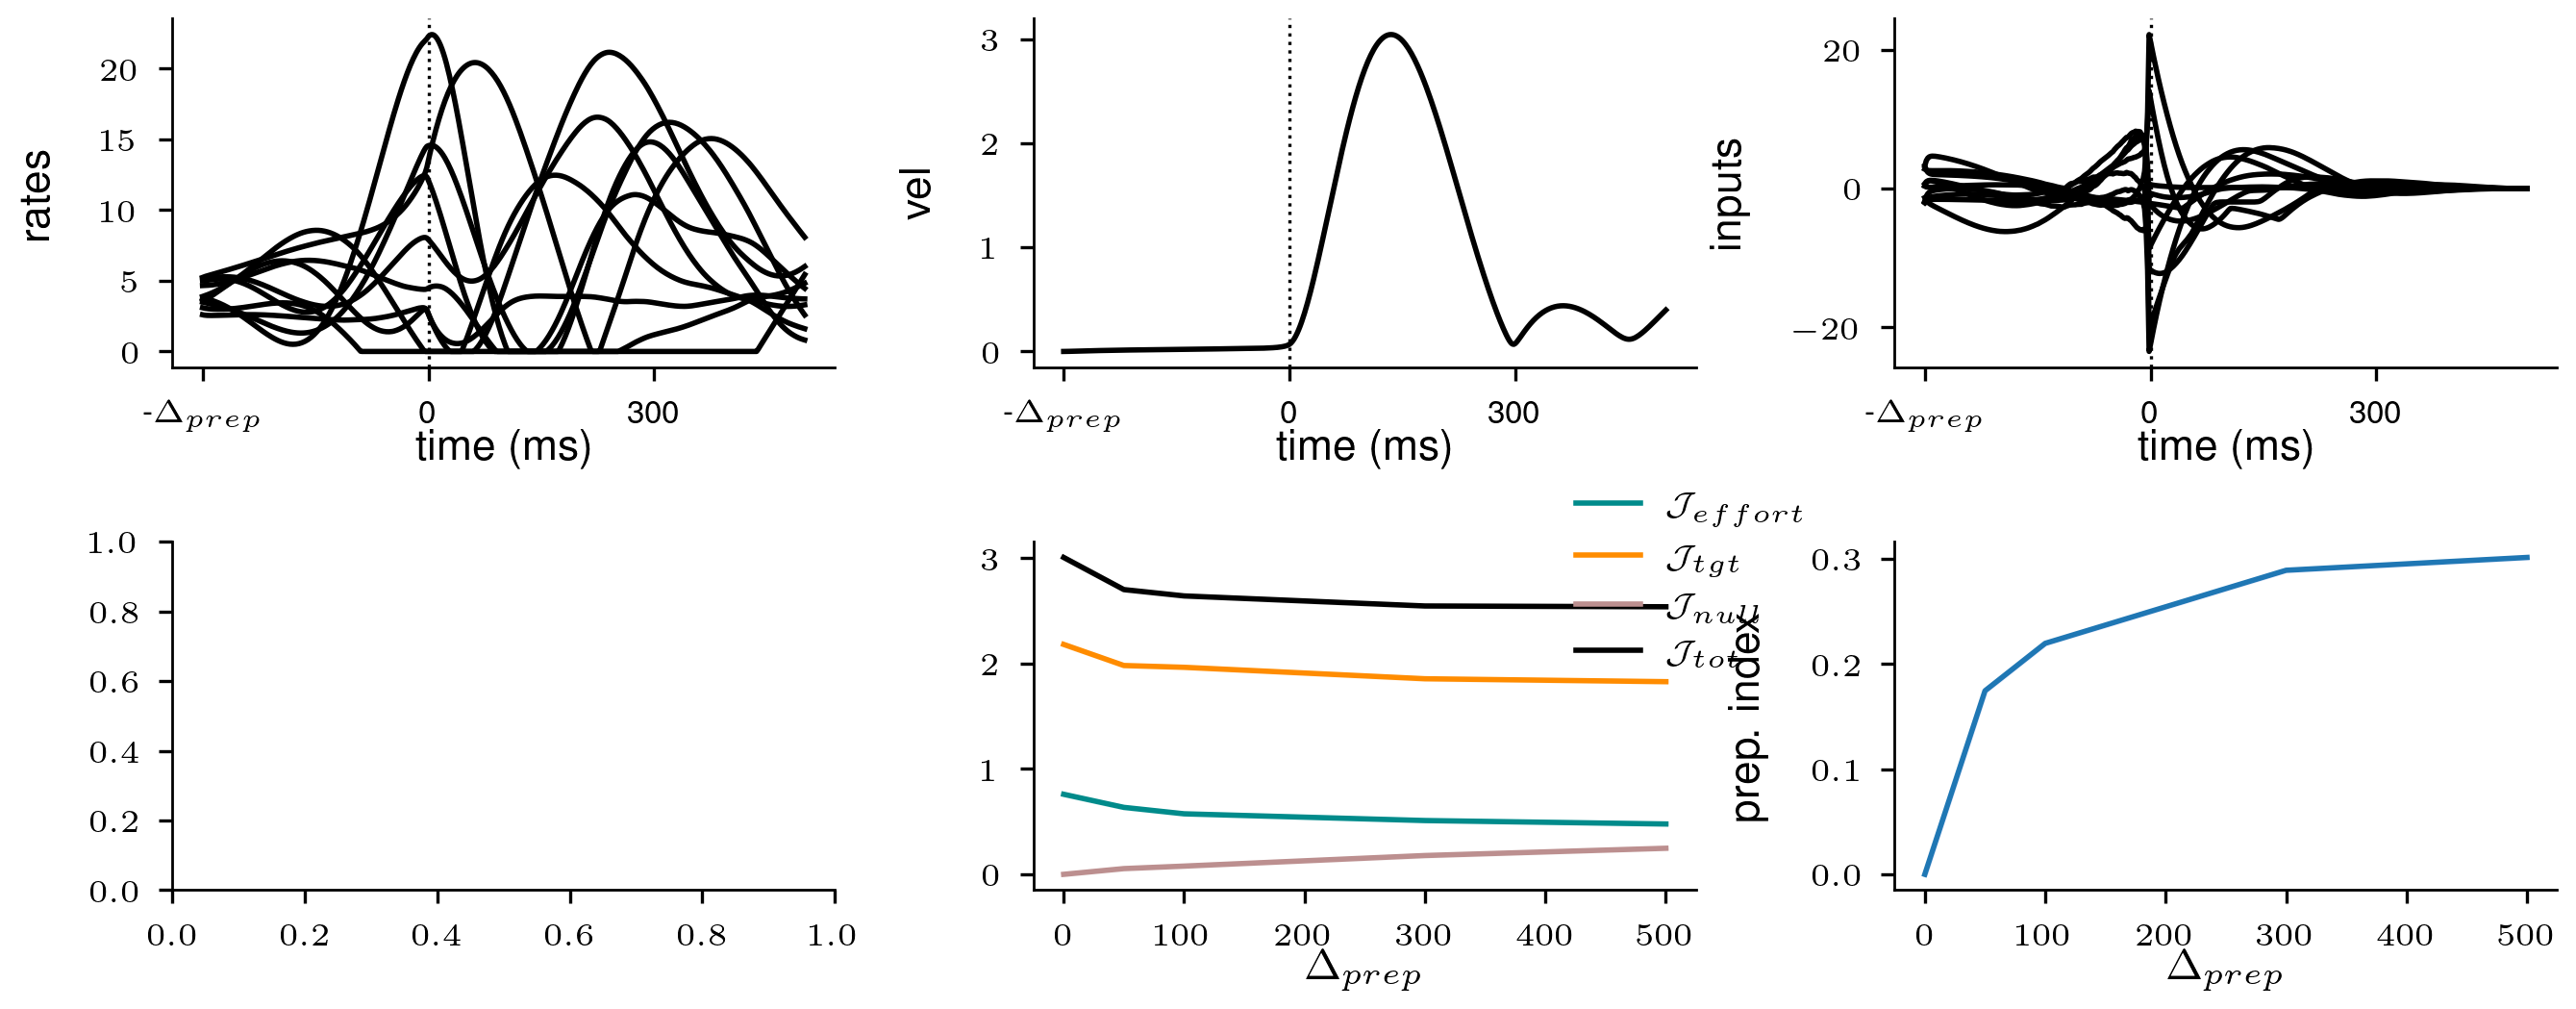

In [35]:
#FIGURE 2
import matplotlib.lines as mlines

fig, axes = plt.subplots(nrows=2, ncols=3,  figsize=(8, 3), dpi = 400)
plt.subplots_adjust(hspace=0.5)
plt.subplots_adjust(wspace=0.3)

cs = ["darkcyan", "darkorange", 'rosybrown', 'indigo', 'deepskyblue', 'royalblue', 'slategray']
neurons = [0, 8, 11, 20, 44, 100, 101, 144, 198, 199]

#plot the trajectories 
for i, n in enumerate(neurons): 
    axes[0, 0].plot(rates(300)[:,n], 'k')
axes[0,0].set_xlabel('time (ms)', labelpad = -0.5)
axes[0,0].set_ylabel('rates')
axes[0,0].axvline(x = 150,c = 'k', linestyle = 'dotted', linewidth = 0.6)
axes[0,0].set_xticks([0,150,300], ['-$\\Delta_{prep}$', '0', '300'])
#plot the inputs
for i, n in enumerate(neurons): 
    axes[0, 2].plot(us(300)[:,n], 'k')
axes[0,2].set_xlabel('time (ms)', labelpad = -0.5)
axes[0,2].set_ylabel('inputs')
axes[0,2].axvline(x = 150,c = 'k', linestyle = 'dotted', linewidth = 0.6)
axes[0,2].set_xticks([0,150,300], ['-$\\Delta_{prep}$', '0', '300'])

# axes[0,2].plot(torques(300)[:,0], 'k')
# axes[0,2].plot(torques(300)[:,1], 'k')
axes[0,1].plot(np.sqrt(mov(300)[:,2]**2 + mov(300)[:,3]**2), 'k')
axes[0,1].set_xlabel('time (ms)', labelpad = -0.5)
axes[0,1].set_ylabel('vel')
axes[0,1].axvline(x = 150,c = 'k', linestyle = 'dotted', linewidth = 0.6)
axes[0,1].set_xticks([0,150,300], ['-$\\Delta_{prep}$', '0', '300'])

mb = m_prep - 1.96*v_prep
mu = m_prep + 1.96*v_prep

axes[1,2].plot(times, m_prep)
axes[1,2].fill_between(times, mb, mu, color='b', alpha=0.05, label='95% confidence')
axes[1,2].set_ylabel('prep. index')
axes[1,2].set_xlabel('$\\Delta_{prep}$', labelpad = -0.5)

mb_u, mu_u = m_cost_u - 1.96*v_cost_u, m_cost_u + 1.96*v_cost_u
mb_tgt, mu_tgt = m_cost_tgt - 1.96*v_cost_tgt, m_cost_tgt + 1.96*v_cost_tgt
mb_torques, mu_torques = m_cost_torques - 1.96*v_cost_torques, m_cost_torques + 1.96*v_cost_torques
mb_loss, mu_loss = m_loss - 1.96*v_loss, m_loss + 1.96*v_loss
axes[1,1].plot(times, m_cost_u, cs[0], label = '$\\mathcal{J}_{effort}$')
axes[1,1].fill_between(times, mb_u, mu_u, color=cs[0], alpha=0.05)
axes[1,1].plot(times, m_cost_tgt, cs[1], label =  '$\\mathcal{J}_{tgt}$')
axes[1,1].fill_between(times, mb_tgt, mu_tgt, color=cs[1], alpha=0.05)
axes[1,1].legend(loc = "upper right")
axes[1,1].plot(times, m_cost_torques, cs[2], label =  '$\\mathcal{J}_{null}$')
axes[1,1].fill_between(times, mb_torques, mu_torques, color=cs[2], alpha=0.05)
axes[1,1].plot(times, m_loss, 'k', label =  '$\\mathcal{J}_{tot}$')
axes[1,1].legend(loc = (0.8,0.6))
axes[1,1].fill_between(times, mb_loss, mu_loss, color='k', alpha=0.05)
axes[1,1].set_xlabel('$\\Delta_{prep}$',labelpad = -0.5)

n_prep = 149
for i in range(n_targets + 1):
    dprojs = proj_prep(i)[1:n_prep-1] - proj_prep(i)[0:n_prep-2]
    dx, dy = dprojs[-1,0], dprojs[-1,1]
    xf, yf = proj_prep(i)[n_prep,0], proj_prep(i)[n_prep,1]
    axes[1,0].plot(proj_prep(i)[:n_prep,0], proj_prep(i)[:n_prep,1], cs[i])
    axes[1,0].arrow(xf,yf,dx,dy, width = 0.02, color = cs[i])
axes[1,0].set_xlabel('PC1')
axes[1,0].set_ylabel('PC2')
#current_pos = axes[0, 4].get_position()
#axes[0, 4].set_position([current_pos.x0 + 0.03, current_pos.y0, current_pos.width, current_pos.height])

fig.text(0.1, 0.92, '$\\textbf{A}$', size = 16)
fig.text(0.36, 0.92, '$\\textbf{B}$', size = 16)
fig.text(0.66, 0.92, '$\\textbf{C}$', size = 16)
fig.text(0.1, 0.46,'$\\textbf{D}$', size = 16)
fig.text(0.36, 0.46, '$\\textbf{E}$', size = 16)
fig.text(0.66, 0.46, '$\\textbf{F}$', size = 16)
#fig.text(-0.05, 0.17, 'iLQR-MAML', rotation = "vertical", size = 20)
#fig.text(0.4, -0.04, 'time', size = 16, ha='center')
#fig.text(0.94, -0.04, 'output 0', size = 16, ha='center')
plt.show()
fig.savefig("fig_2.pdf", format = "pdf", bbox_inches='tight')


***Figure 3***

In [ ]:
vprep = np.loadtxt("/home/mmcs3/rds/rds-t2-cs156-T7o4pEA8QoU/mmcs3/random_monkeys_random_lambda_1E-6/ramping/seed_3/analysis/vprep")
vmov = np.loadtxt("/home/mmcs3/rds/rds-t2-cs156-T7o4pEA8QoU/mmcs3/random_monkeys_random_lambda_1E-6/ramping/seed_3/analysis/vmov")
def proj_mov(i):
    return np.loadtxt(f"/home/mmcs3/rds/rds-t2-cs156-T7o4pEA8QoU/mmcs3/random_monkeys_random_lambda_1E-6/ramping/seed_3/analysis/proj_mov_{i}")

def proj_prep(i):
    return np.loadtxt(f"/home/mmcs3/rds/rds-t2-cs156-T7o4pEA8QoU/mmcs3/random_monkeys_random_lambda_1E-6/ramping/seed_3/analysis/proj_prep_{i}")

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import itertools
dir = f"/home/mmcs3/rds/rds-t2-cs156-T7o4pEA8QoU/mmcs3/random_monkeys_random_lambda_4E-6/ramping/seed_{seed}_250_2_1.5_nodt"

palette = sns.color_palette("coolwarm_r",8)
print(palette)


In [ ]:
def realign(ax, frac, offset=0):
    ax.set_yticks([])
    ax.set_xticks([])
    ax.spines["left"].set_visible(False)
    ax.spines["right"].set_visible(True)
    current_pos = ax.get_position()
    new_width = frac*current_pos.width
    ax.set_position([current_pos.x0 + offset + current_pos.width - new_width, current_pos.y0, new_width, current_pos.height])


def rates(t, i = 3):
    return np.loadtxt(f'{dir}/rates_{i}_{t}')

def us(t, i = 3):
    return np.loadtxt(f'{dir}/us_{i}_{t}')


max_size = 13
fig = plt.figure(figsize=(8, 3), dpi = 400)
plt.subplots_adjust(hspace=0.45)
gs = gridspec.GridSpec(5, 3)
ax1 = plt.subplot(gs[0, 0])
realign(ax1, frac=5/max_size, offset = 0.015)
ax1.spines["left"].set_visible(False)
ax1.spines["right"].set_visible(True)
ax2 = plt.subplot(gs[1, 0])
realign(ax2, frac=5.5/max_size, offset = 0.015)
ax3 = plt.subplot(gs[2, 0])
realign(ax3, frac=8/max_size, offset = 0.015)
ax4 = plt.subplot(gs[3, 0])
realign(ax4, frac=10/max_size, offset = 0.015)
ax5 = plt.subplot(gs[4, 0])
realign(ax5, frac=1, offset = 0.015)
ax5.set_xticks([0,400,550], ['-800', '0', '300'])
#ax6 = plt.subplot(gs[5, 0])
ax7 = plt.subplot(gs[0, 1])
realign(ax7, frac=5/max_size)
ax8 = plt.subplot(gs[1, 1])
realign(ax8, frac=5.5/max_size)
ax9 = plt.subplot(gs[2, 1])
realign(ax9, frac=8/max_size)
ax10 = plt.subplot(gs[3, 1])
realign(ax10, frac=10/max_size)
ax11 = plt.subplot(gs[4, 1])
realign(ax11, frac=1)
ax11.set_xticks([0,400,550], ['-800', '0', '300'])
#ax12 = plt.subplot(gs[5, 1])
ax131 = plt.subplot(gs[0, 2])
ax132 = plt.subplot(gs[1, 2])
ax14 = plt.subplot(gs[2:, 2])

###############################
ax1.plot(us(0)[:,:40:4])
ax2.plot(us(50)[:,:40:4])
ax3.plot(us(300)[:,:40:4])
ax4.plot(us(500)[:,:40:4])
ax5.plot(us(800)[:,:40:4])
ax7.plot(rates(0)[:,:40:4])
ax8.plot(rates(50)[:,:40:4])
ax9.plot(rates(300)[:,:40:4])
ax10.plot(rates(500)[:,:40:4])
ax11.plot(rates(800)[:,:40:4])

current_pos = ax131.get_position()
ax131.set_position([current_pos.x0 + 0.05, current_pos.y0, current_pos.width, 0.12])
for i in np.arange(8):
    ax131.plot(proj_prep(i)[:,0], color = palette[i])
ax131.axvline(x = 250,c = 'k', linestyle = 'dotted', linewidth = 0.6)
ax131.set_xticks([])
ax131.set_yticks([-2.5,0.,2.5],[-2.5,0.,2.5])
ax131.set_ylabel("prep. proj")
current_pos = ax132.get_position()
ax132.set_position([current_pos.x0 + 0.05, current_pos.y0 - 0.05, current_pos.width, 0.12])
for i in np.arange(8):
    ax132.plot(proj_mov(i)[:,0], color = palette[i])
ax132.axvline(x = 250,c = 'k', linestyle = 'dotted', linewidth = 0.6)
ax132.set_xticks([])
ax132.set_yticks([-2.5,0.,2.5],[-2.5,0.,2.5])
ax132.set_ylabel("mov. proj")
current_pos = ax14.get_position()
ax14.set_position([current_pos.x0 + 0.05, current_pos.y0, current_pos.width, 0.32])
ax14.plot(vmov, label = "mov")
ax14.plot(vprep, label = "prep")
ax14.axvline(x = 250,c = 'k', linestyle = 'dotted', linewidth = 0.6)
ax14.legend()
ax14.set_ylabel("occupancy")
ax14.set_xlabel("time (ms)")
ax14.set_xticks([0,250,400], ['-$\\Delta_{\\textrm{prep}}$', '0', '300'])
ax14.set_yticks([0,1], [0,1.0])
fig.text(0.38, 0.01, 'time (ms)', size = fs, ha='center')
fig.text(0.3, 0.95, '\\textbf{inputs}', size = fs, ha='center')
fig.text(0.5, 0.95, '\\textbf{rates}', size = fs, ha='center')
fig.text(0.24, 0.81, '0ms', ha='center', rotation = "vertical")
fig.text(0.21, 0.63, '50ms', ha='center', rotation = "vertical")
fig.text(0.18, 0.45, '300ms', ha='center', rotation = "vertical")
fig.text(0.15, 0.28, '500ms', ha='center', rotation = "vertical")
fig.text(0.11, 0.1, '800ms', ha='center', rotation = "vertical")
fig.text(0.1, 0.94, '$\\textbf{A}$', size = 16)
fig.text(0.66, 0.94, '$\\textbf{B}$', size = 16)
plt.show()
fig.savefig("fig_3.pdf", format = "pdf", bbox_inches='tight')

## Occupancies plot

In [ ]:
vprep_soc = np.loadtxt("/home/mmcs3/rds/rds-t2-cs156-T7o4pEA8QoU/mmcs3/random_monkeys_random_lambda_1E-6/ramping/seed_1/analysis/vprep")
vmov_soc = np.loadtxt("/home/mmcs3/rds/rds-t2-cs156-T7o4pEA8QoU/mmcs3/random_monkeys_random_lambda_1E-6/ramping/seed_1/analysis/vmov")
vprep_skew_2 = np.loadtxt("/home/mmcs3/rds/rds-t2-cs156-T7o4pEA8QoU/mmcs3/random_monkeys_random_lambda_1E-6/ramping_skew/rad_2./analysis/vprep")
vmov_skew_2 = np.loadtxt("/home/mmcs3/rds/rds-t2-cs156-T7o4pEA8QoU/mmcs3/random_monkeys_random_lambda_1E-6/ramping_skew/rad_2./analysis/vmov")
vprep_rdn_2 = np.loadtxt("/home/mmcs3/rds/rds-t2-cs156-T7o4pEA8QoU/mmcs3/random_monkeys_random_lambda_1E-6/ramping_rdn/rad_2./analysis/vprep")
vmov_rdn_2 = np.loadtxt("/home/mmcs3/rds/rds-t2-cs156-T7o4pEA8QoU/mmcs3/random_monkeys_random_lambda_1E-6/ramping_rdn/rad_2./analysis/vmov")
vprep_skew_05 = np.loadtxt("/home/mmcs3/rds/rds-t2-cs156-T7o4pEA8QoU/mmcs3/random_monkeys_random_lambda_1E-6/ramping_skew/rad_0.5/analysis/vprep")
vmov_skew_05 = np.loadtxt("/home/mmcs3/rds/rds-t2-cs156-T7o4pEA8QoU/mmcs3/random_monkeys_random_lambda_1E-6/ramping_skew/rad_0.5/analysis/vmov")
vprep_rdn_05 = np.loadtxt("/home/mmcs3/rds/rds-t2-cs156-T7o4pEA8QoU/mmcs3/random_monkeys_random_lambda_1E-6/ramping_rdn/rad_0.5/analysis/vprep")
vmov_rdn_05 = np.loadtxt("/home/mmcs3/rds/rds-t2-cs156-T7o4pEA8QoU/mmcs3/random_monkeys_random_lambda_1E-6/ramping_rdn/rad_0.5/analysis/vmov")

fig, axes = plt.subplots(nrows=2, ncols=3,  figsize=(8, 3), dpi = 400)

cs = ["darkcyan", 'rosybrown', "darkorange",  'indigo', 'deepskyblue', 'royalblue']
neurons = [0, 8, 11, 20, 44, 100, 101, 144, 198, 199]

#plot the trajectories 
axes[1,0].set_xlabel('time (ms)', labelpad = -0.5)
axes[1,0].plot(vprep_soc, cs[0], label="prep.")
axes[1,0].plot(vmov_soc, cs[1], label="mov.")
axes[1,0].legend()

axes[0,1].plot(vprep_rdn_05, cs[0])
axes[0,1].plot(vmov_rdn_05, cs[1])

axes[1,1].set_xlabel('time (ms)', labelpad = -0.5)
axes[1,1].plot(vprep_rdn_2, cs[0])
axes[1,1].plot(vmov_rdn_2, cs[1])

axes[0,2].plot(vprep_skew_05, cs[0])
axes[0,2].plot(vmov_skew_05, cs[1])

axes[1,2].set_xlabel('time (ms)', labelpad = -0.5)
axes[1,2].plot(vprep_skew_2, cs[0])
axes[1,2].plot(vmov_skew_2, cs[1])

### Fig1 : Illustrative plot of the task + cost 

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Polygon, Rectangle
from pdf2image import convert_from_path

n_targets = 8
cs = ["darkcyan", "darkorange", 'darkblue', 'deepskyblue', 'slategray']
neurons = [0, 8, 11, 20, 44, 100, 101, 144, 198, 199]
palette = sns.color_palette("hls",10)

fig = plt.figure(figsize=(8, 3), dpi = 400)
plt.subplots_adjust(hspace=0.45)
plt.subplots_adjust(wspace=1)
gs = gridspec.GridSpec(4, 7)
ax0 = plt.subplot(gs[:, :2])
ax1_top = plt.subplot(gs[:2, 2:3])
ax1_bot = plt.subplot(gs[2:3, 2:3])
ax1_botbot = plt.subplot(gs[3:, 2:3])
ax2 = plt.subplot(gs[:2, 3:5])
ax3 = plt.subplot(gs[2:, 3:5])
ax4 = plt.subplot(gs[:2, 5:])
ax5 = plt.subplot(gs[2:, 5:])
full_width = ax5.get_position().width
# ax6 = plt.subplot(gs[:2, 8:11])
# ax7 = plt.subplot(gs[2, 4:])
# ax8 = plt.subplot(gs[3,8:11])
im = convert_from_path('/home/mmcs3/code/why-prep-2/data/arm_model.pdf')
im = np.array(im[0]) # insert local path of the image.
# fig.delaxes(axes[1,0])
mov_inpts =  np.loadtxt("/home/mmcs3/rds/rds-t2-cs156-T7o4pEA8QoU/mmcs3/random_monkeys_random_lambda_1E-6/ramping/seed_1_0.01_mov/us_4_300")
prep_inpts =  np.loadtxt("/home/mmcs3/rds/rds-t2-cs156-T7o4pEA8QoU/mmcs3/random_monkeys_random_lambda_1E-6/ramping/seed_1_0.01_prep/us_4_300")
mov_activity =  np.loadtxt("/home/mmcs3/rds/rds-t2-cs156-T7o4pEA8QoU/mmcs3/random_monkeys_random_lambda_1E-6/ramping/seed_1_0.01_mov/rates_4_300")
prep_activity = np.loadtxt("/home/mmcs3/rds/rds-t2-cs156-T7o4pEA8QoU/mmcs3/random_monkeys_random_lambda_1E-6/ramping/seed_1_0.01_prep/rates_4_300")
prep_hands = np.loadtxt("/home/mmcs3/rds/rds-t2-cs156-T7o4pEA8QoU/mmcs3/random_monkeys_random_lambda_1E-7/prep_only_soc/hands_4_300")
mov_hands = np.loadtxt("/home/mmcs3/rds/rds-t2-cs156-T7o4pEA8QoU/mmcs3/random_monkeys_random_lambda_1E-7/mov_only_soc/hands_4_300")
hand_targets = np.loadtxt(f"/home/mmcs3/rds/rds-t2-cs156-T7o4pEA8QoU/mmcs3/random_monkeys_random_lambda_1E-7/mov_only_soc/hand_targets")
torques_prep = np.loadtxt("/home/mmcs3/rds/rds-t2-cs156-T7o4pEA8QoU/mmcs3/random_monkeys_random_lambda_1E-6/ramping/seed_1_0.01_prep/torques_4_300")
torques_mov = np.loadtxt("/home/mmcs3/rds/rds-t2-cs156-T7o4pEA8QoU/mmcs3/random_monkeys_random_lambda_1E-6/ramping/seed_1_0.01_mov/torques_4_300")
pos = ax0.get_position()
ax0.set_position([pos.x0 - 0.06, pos.y0 - 0.15, 1.1*pos.width, 1.4*pos.height])
ax0.imshow(im)
ax0.set_yticks([])
ax0.set_xticks([])
ax0.spines["left"].set_visible(False)
ax0.spines["bottom"].set_visible(False)

##Targets and velocity
#targets
ax1_top.set_yticks([])
ax1_top.set_xticks([])
pos1 = ax1_top.get_position()
ax1_top.set_position([pos1.x0 - 0.4*pos1.width - 0.04, pos1.y0, 1.4*pos1.width, 0.7*pos1.height])
for i in np.arange(n_targets):
    ax1_top.plot(hand_targets[i,0], hand_targets[i,1], 'o', color = palette[i])

ax1_top.plot(prep_hands[:,0] - prep_hands[0,0], prep_hands[:,2] - prep_hands[0,2], cs[0])
ax1_top.plot(mov_hands[:,0] - mov_hands[0,0], mov_hands[:,2] - mov_hands[0,2], cs[1])
ax1_top.spines["bottom"].set_visible(False)
ax1_top.spines["left"].set_visible(False)
# ax1_top.spines["top"].set_visible(True)
# ax1_top.spines["right"].set_visible(True)
ax1_top.set_xlabel("x1")
ax1_top.set_ylabel("x2")
#velocity
pos1 = ax1_bot.get_position()
ax1_bot.set_position([pos1.x0 - full_width + pos1.width + 0.02, pos1.y0  - 0.01,full_width, 0.7*pos1.height])
ax1_bot.plot(np.sqrt(prep_hands[:,3]**2 + prep_hands[:,1]**2), cs[0])
ax1_bot.plot(np.sqrt(mov_hands[:,3]**2 + mov_hands[:,1]**2), cs[1])
ax1_bot.set_yticks([0,1], [0,1])
ax1_bot.set_xticks([])
ax1_bot.set_ylabel("vel.")
ax1_bot.spines["bottom"].set_visible(False)
#torques
pos1 = ax1_botbot.get_position()
ax1_botbot.set_position([pos1.x0 - full_width + pos1.width + 0.02, pos1.y0,full_width, 0.7*pos1.height])
ax1_botbot.plot(torques_prep, cs[1])
ax1_botbot.plot(torques_mov, cs[0])
ax1_botbot.set_yticks([-2.5,0,2.5], [-2.5,0,2.5])
ax1_botbot.set_xticks([0,150,300], ['$\\Delta_{\\textrm{prep}}$', 'Go', '300'])
ax1_botbot.set_ylabel("torques",labelpad = -0.2)
#prep and move
ax2.set_xticks([])
ax2.set_yticks([-50,0,50, 100], [-50,0,50,100])
ax2.set_ylim(-60, 110)
ax2.spines["bottom"].set_visible(False)
ax4.set_xticks([])
ax4.set_yticks([])
ax4.set_ylim(-60, 110)
ax4.spines["bottom"].set_visible(False)
ax3.set_xticks([0,150,300], ['$\\Delta_{\\textrm{prep}}$', 'Go', '300'])
ax3.set_yticks([0,20, 40], [0,20, 40])
ax3.set_ylim(0,58)
ax5.set_xticks([0,150,300], ['$\\Delta_{\\textrm{prep}}$', 'Go', '300'])
ax5.set_yticks([])
ax5.set_ylim(0,58)
ax3.set_xlabel("time (ms)")
for i in neurons : 
    ax3.plot(mov_activity[:,i], cs[0])
    ax2.plot(mov_inpts[:,i], cs[0])
    ax5.plot(prep_activity[:,i], cs[1])
    ax4.plot(prep_inpts[:,i], cs[1])

#slight shift downard of the inputs
pos2 = ax2.get_position()
ax2.set_position([pos2.x0, pos2.y0, pos2.width, 0.8*pos2.height])
ax2.set_title("$\\textbf{Mov. only}$", fontsize = fs_p1)
left, bottom, width, height = [0.51, 0.325, 0.04, 0.06]
# ax_mov = fig.add_axes([left, bottom, width, height])
# ax_mov.plot(torques_mov, cs[0])
# ax_mov.set_yticks([-2,2], [-2,2])
# ax_mov.set_xticks([])
#prep torques
left, bottom, width, height = [0.745, 0.325, 0.04, 0.06]
# ax_prep = fig.add_axes([left, bottom, width, height])
# ax_prep.plot(torques_prep, cs[1])
# ax_prep.set_yticks([-2,2], [-2,2])
# ax_prep.set_xticks([])
# pos6 = ax6.get_position()
pos4 = ax4.get_position()
ax4.set_position([pos4.x0, pos4.y0, pos4.width, 0.8*pos4.height])
ax4.set_title("$\\textbf{Prep. only}$", fontsize = fs_p1)
ax2.set_ylabel('inputs', labelpad = -0.2)
ax3.set_ylabel('rates', labelpad = -0.2)
# pts = np.array([[3/7,0.6], [1,0.6], [1,1]])
# p = Polygon(pts, closed=False, alpha = 0.4, color = cs[2])
# ax6.add_patch(p)
# r1 = Rectangle(xy = (0,0.4), width = 3/7, height = 0.2, color = cs[3], alpha = 0.4)
# r2 = Rectangle(xy = (0,0.2), width = 1, height = 0.2, color = cs[4], alpha = 0.4)
# ax6.add_patch(r1)
# ax6.add_patch(r2)
# ax6.text(0.4, 0.25, '$\\mathcal{J}_{effort}$', size = 12)
# ax6.text(0.8, 0.7, '$\\mathcal{J}_{tgt}$', size = 12)
# ax6.text(0.15, 0.45, '$\\mathcal{J}_{null}$', size = 12)
# ax6.set_xticks([])
# ax6.set_yticks([])
# ax6.spines["bottom"].set_visible(False)
# ax6.spines["left"].set_visible(False)
# ax6.plot(0,0.1,'ko')
# ax6.plot(3/7,0.1,'ko')
# ax6.plot(1,0.1,'ko')
# ax6.text(-0.05,-0.05,"Tgt")
# ax6.text(3/7-0.05,-0.05,"Go")
# ax6.text(1-0.05,-0.05,"End")

# pos7 = ax7.get_position()
# ax7.plot(torques_prep, cs[0])
# ax7.plot(torques_mov, cs[1], ls = "dotted")
# ax7.set_xticks([])
# ax7.set_ylabel('torques', labelpad = -0.5)
# ax7.spines["bottom"].set_visible(False)
# pos8 = ax8.get_position()
# ax8.plot(np.sqrt(prep_thetas[:,1]**2 + prep_thetas[:,2]**2), cs[0])
# ax8.plot(np.sqrt(mov_thetas[:,1]**2 + mov_thetas[:,2]**2), cs[1], ls = "dotted")
# ax8.set_ylabel('vel.', labelpad = -0.5)
# ax8.set_xlabel('time (ms)')
# ax8.set_xticks([0,150,300], ['$\\Delta_{prep}$', 'Go', '300'])
fig.text(0.1, 0.88, '$\\textbf{A}$', size = 16)
fig.text(0.44, 0.88, '$\\textbf{B}$', size = 16)
plt.show()
fig.savefig("fig_1_test.pdf", format = "pdf", bbox_inches='tight')


### Suppl fig 1 : reaction time, hand velocity and reaches to different targets for different prep levels

In [ ]:
dir = f"/home/mmcs3/rds/rds-t2-cs156-T7o4pEA8QoU/mmcs3/random_monkeys_random_lambda_6E-6/ramping/seed_{seed}_250_2_1.5_nodt"
targets = np.loadtxt(f'/home/mmcs3/rds/rds-t2-cs156-T7o4pEA8QoU/mmcs3/random_monkeys_lambda_1E-6/seed_4/targets')
times = [0,50,100,300]
cs = ["r", "skyblue", "forestgreen", "navy", "pink"]
ls = ["solid", "dotted"]
def reaction_time():
    def get_mov_time(mov, t):
        vel = np.sqrt(mov[:,2]**2 + mov[:,3]**2)
        threshold = 0.1* np.max(vel)
        idces = np.argwhere(vel > threshold)
        min_idx = np.min(idces)
        return min_idx * 0.002 - t*0.001
    def get_all_idces(i):
        ai = np.asarray([get_mov_time(mov(t, i),t) for t in times])
        return ai
    movs = range(n_targets)
    idces = np.concatenate([get_all_idces(i)[:,None] for i in movs], axis=1)
    m, v = np.mean(idces, axis=1), np.std(idces, axis=1)/np.sqrt(n_targets)
    return m, v

def mov(t, i = 0):
    return np.loadtxt(f'{dir}/thetas_{i}_{t}')


fig, axes = plt.subplots(nrows=1, ncols=3,  figsize=(8, 1.5), dpi = 400)
plt.subplots_adjust(hspace=0.5)
plt.subplots_adjust(wspace=0.3)
m_reac, v_reac = reaction_time()

axes[0].plot(targets[:,0],targets[:,1],"ko")
for i,t in enumerate([0,50]):
    axes[0].plot(mov(t,0)[:,0], mov(t,0)[:,1], color = cs[i], linestyle = ls[i])

for i,t in enumerate(times):
    axes[1].plot(np.sqrt(mov(t,0)[:,2]**2 + mov(t,0)[:,3]**2), cs[i])
axes[1].set_xticks([0,150,300], [0,300,600])
mb_reac, mu_reac = m_reac - 1.96*v_reac, m_reac + 1.96*v_reac
axes[2].plot(times, m_reac, 'k', label = '$\\mathcal{J}_{effort}$')
axes[2].fill_between(times, mb_reac, mu_reac, color='k', alpha=0.05)

fig.text(0.1, 0.92, '$\\textbf{A}$', size = 16)
fig.text(0.36, 0.92, '$\\textbf{B}$', size = 16)
fig.text(0.66, 0.92, '$\\textbf{C}$', size = 16)


### Similarity plot

In [ ]:
dir = f"/home/mmcs3/rds/rds-t2-cs156-T7o4pEA8QoU/mmcs3/random_monkeys_random_lambda_6E-6/ramping/seed_{seed}_250_2_1.5_nodt"
times = [0, 50, 300, 500, 800]
def rates(t, i = 0):
    return np.loadtxt(f'{dir}/rates_{i}_{t}')

def us(t, i = 0):
    return np.loadtxt(f'{dir}/us_{i}_{t}')

def build_matrix():
    ls = []
    for t in times:
        n = int(t/2)
        ac = rates(t)[n,:][None,:]
        ac = ac/(np.linalg.norm(ac))
        ls.append(ac)
    acs = np.concatenate(ls, axis=0) #Nt x N
    return acs@acs.T

mat = build_matrix()
plt.imshow(mat, cmap="rainbow")
plt.colorbar()
plt.xticks([0,1,2,3,4], times)
plt.yticks([0,1,2,3,4], times)
plt.xlabel('$\\Delta_{prep}$')
plt.ylabel('$\\Delta_{prep}$')

### Visualization of prep and move without occupancy

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

dir = f"/home/mmcs3/rds/rds-t2-cs156-T7o4pEA8QoU/mmcs3/random_monkeys_random_lambda_4E-6/ramping/seed_{seed}_250_2_1.5_nodt"

def realign(ax, frac, offset=0):
    ax.set_yticks([])
    ax.set_xticks([])
    ax.spines["left"].set_visible(False)
    ax.spines["right"].set_visible(True)
    current_pos = ax.get_position()
    new_width = frac*current_pos.width
    ax.set_position([current_pos.x0 + offset + current_pos.width - new_width, current_pos.y0, new_width, current_pos.height])


def rates(t, i = 3):
    return np.loadtxt(f'{dir}/rates_{i}_{t}')

def us(t, i = 3):
    return np.loadtxt(f'{dir}/us_{i}_{t}')


max_size = 13
fig = plt.figure(figsize=(6, 3), dpi = 400)
plt.subplots_adjust(hspace=0.45)
gs = gridspec.GridSpec(5, 2)
ax1 = plt.subplot(gs[0, 0])
realign(ax1, frac=5/max_size, offset = 0.015)
ax1.spines["left"].set_visible(False)
ax1.spines["right"].set_visible(True)
ax2 = plt.subplot(gs[1, 0])
realign(ax2, frac=5.5/max_size, offset = 0.015)
ax3 = plt.subplot(gs[2, 0])
realign(ax3, frac=8/max_size, offset = 0.015)
ax4 = plt.subplot(gs[3, 0])
realign(ax4, frac=10/max_size, offset = 0.015)
ax5 = plt.subplot(gs[4, 0])
realign(ax5, frac=1, offset = 0.015)
ax5.set_xticks([0,400,550], ['-800', '0', '300'])
#ax6 = plt.subplot(gs[5, 0])
ax7 = plt.subplot(gs[0, 1])
realign(ax7, frac=5/max_size)
ax8 = plt.subplot(gs[1, 1])
realign(ax8, frac=5.5/max_size)
ax9 = plt.subplot(gs[2, 1])
realign(ax9, frac=8/max_size)
ax10 = plt.subplot(gs[3, 1])
realign(ax10, frac=10/max_size)
ax11 = plt.subplot(gs[4, 1])
realign(ax11, frac=1)
ax11.set_xticks([0,400,550], ['-800', '0', '300'])
#ax12 = plt.subplot(gs[5, 1])
###############################
ax1.plot(us(0)[:,:40:4])
ax2.plot(us(50)[:,:40:4])
ax3.plot(us(300)[:,:40:4])
ax4.plot(us(500)[:,:40:4])
ax5.plot(us(800)[:,:40:4])
ax7.plot(rates(0)[:,:40:4])
ax8.plot(rates(50)[:,:40:4])
ax9.plot(rates(300)[:,:40:4])
ax10.plot(rates(500)[:,:40:4])
ax11.plot(rates(800)[:,:40:4])


fig.text(0.5, 0.01, 'time (ms)', size = fs, ha='center')
fig.text(0.4, 0.95, '\\textbf{inputs}', size = fs, ha='center')
fig.text(0.7, 0.95, '\\textbf{rates}', size = fs, ha='center')
fig.text(0.24, 0.81, '0ms', ha='center', rotation = "vertical")
fig.text(0.21, 0.63, '50ms', ha='center', rotation = "vertical")
fig.text(0.18, 0.45, '300ms', ha='center', rotation = "vertical")
fig.text(0.15, 0.28, '500ms', ha='center', rotation = "vertical")
fig.text(0.11, 0.1, '800ms', ha='center', rotation = "vertical")
# fig.text(0.1, 0.94, '$\\textbf{A}$', size = 16)
# fig.text(0.7, 0.94, '$\\textbf{B}$', size = 16)
plt.show()
fig.savefig("fig_3_cropped.pdf", format = "pdf", bbox_inches='tight')

### Fig 4 : Double reach plot

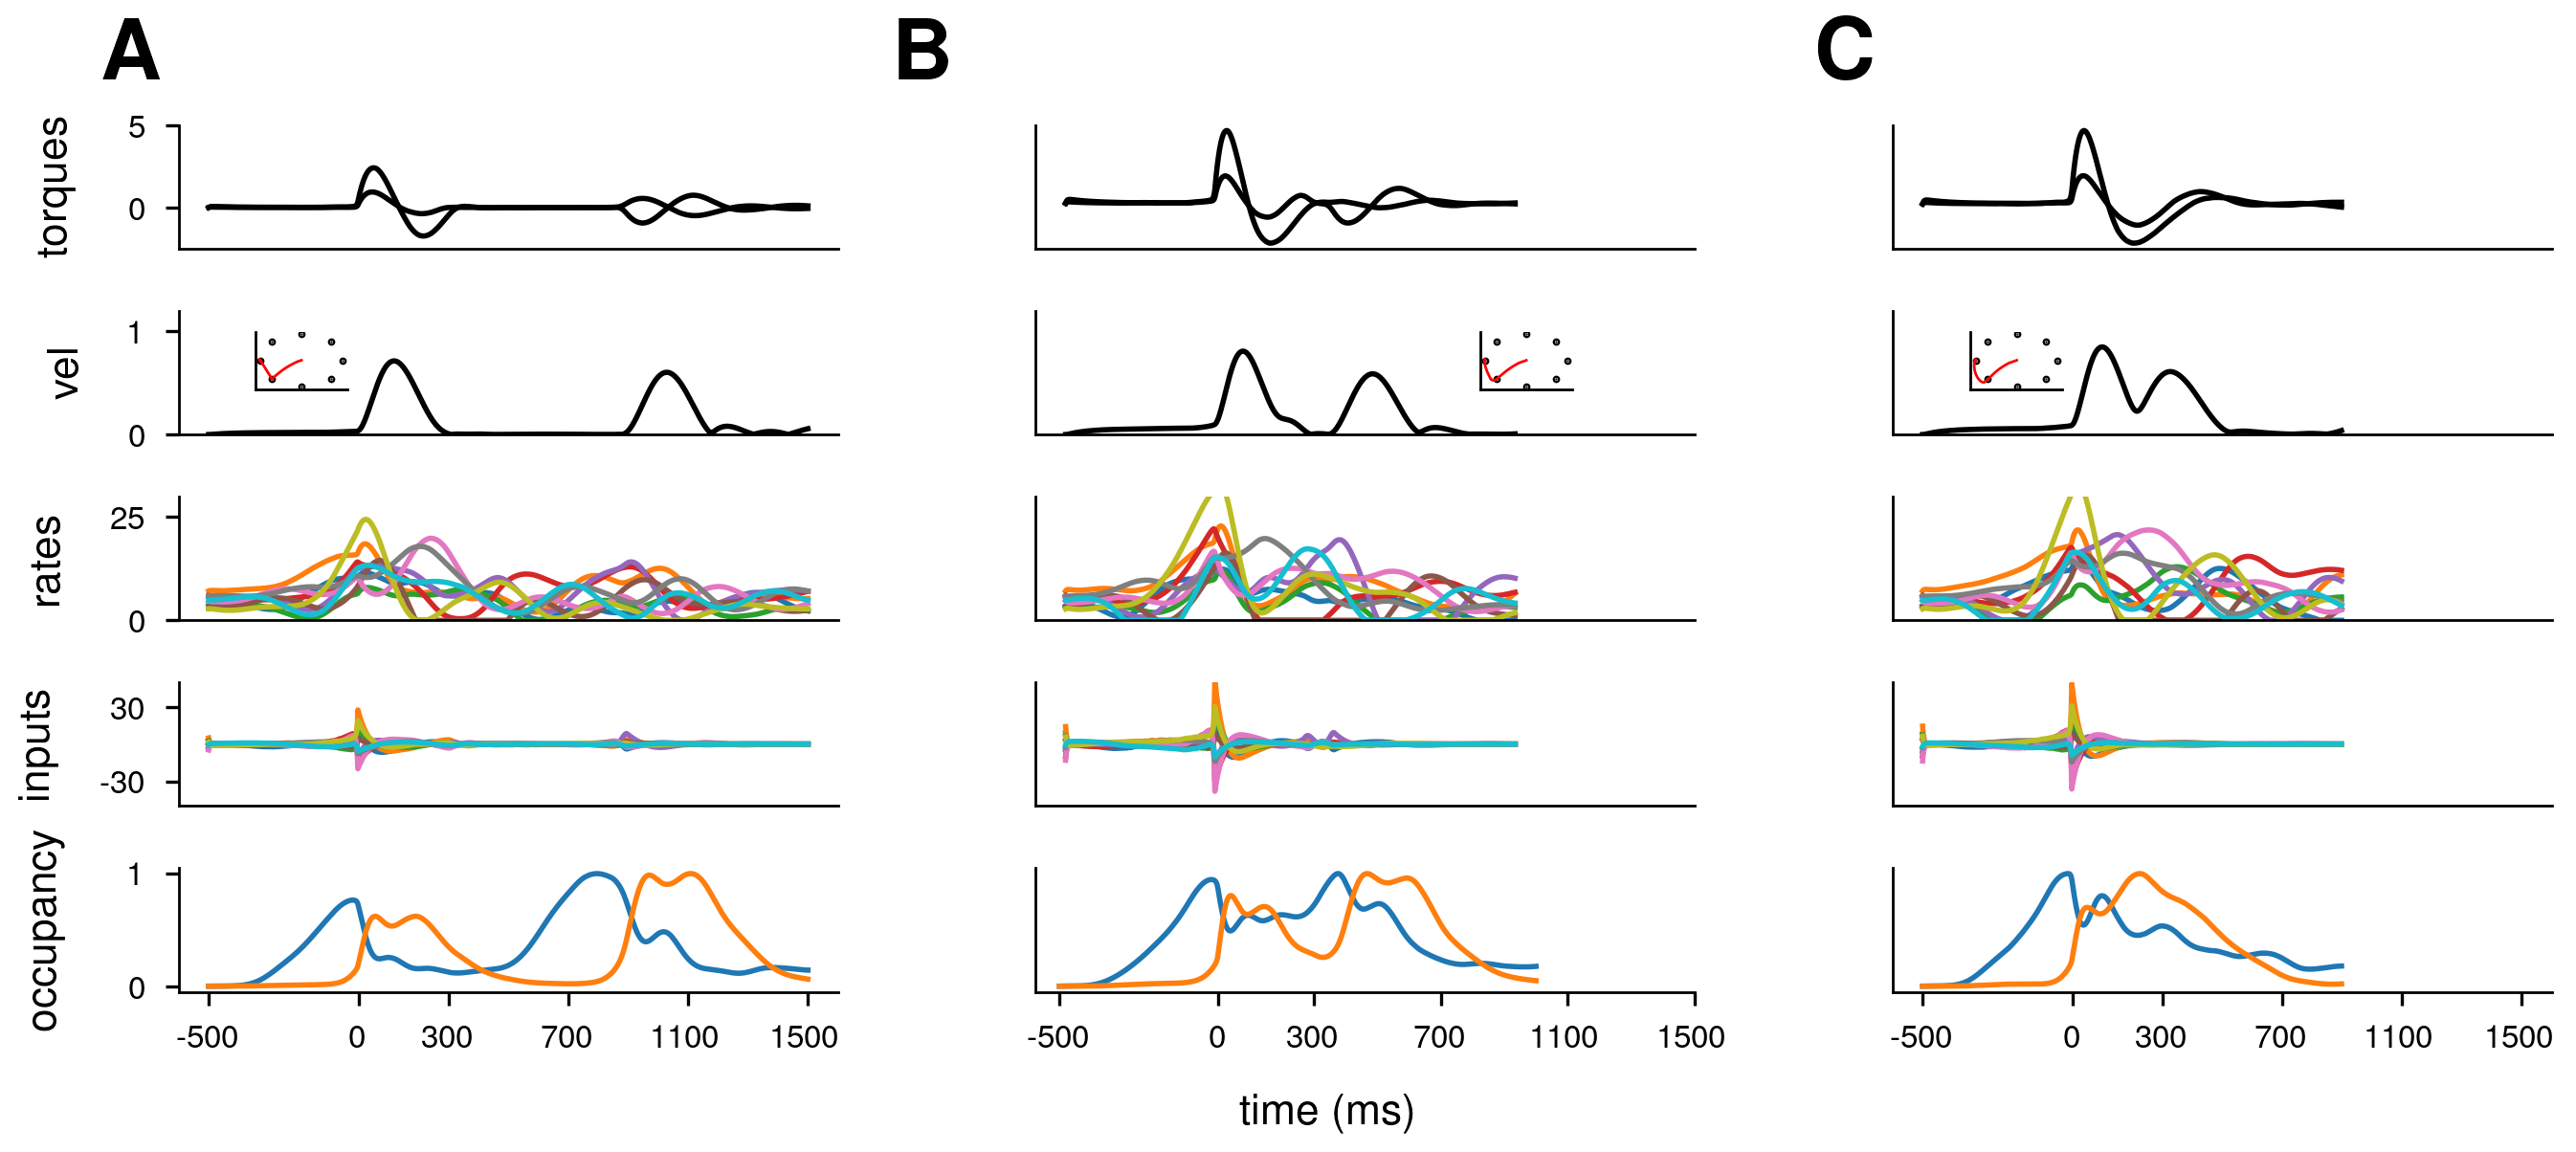

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

double_dir = "/home/mmcs3/rds/rds-t2-cs156-T7o4pEA8QoU/mmcs3/random_monkeys_random_lambda_2E-6/ramping/seed_5_200_2/double_ramping_2003002_pause_0.6_1._0.000002_300400"
compound_dir = "/home/mmcs3/rds/rds-t2-cs156-T7o4pEA8QoU/mmcs3/random_monkeys_random_lambda_2E-6/ramping/seed_5_200_2/double_ramping_1002002_pause_0._1._0.000002_300400"
compound_pause_dir = "/home/mmcs3/rds/rds-t2-cs156-T7o4pEA8QoU/mmcs3/random_monkeys_random_lambda_2E-6/ramping/seed_5_200_2/double_ramping_1002002_pause_0.1_1._0.000002_300400"

vprep_long = np.loadtxt("/home/mmcs3/rds/rds-t2-cs156-T7o4pEA8QoU/mmcs3/random_monkeys_random_lambda_2E-6/ramping/seed_5_200_2/double_projs_long/vprep")
vmov_long = np.loadtxt("/home/mmcs3/rds/rds-t2-cs156-T7o4pEA8QoU/mmcs3/random_monkeys_random_lambda_2E-6/ramping/seed_5_200_2/double_projs_long/vmov")
vprep_short = np.loadtxt("/home/mmcs3/rds/rds-t2-cs156-T7o4pEA8QoU/mmcs3/random_monkeys_random_lambda_2E-6/ramping/seed_5_200_2/double_projs/vprep")
vmov_short = np.loadtxt("/home/mmcs3/rds/rds-t2-cs156-T7o4pEA8QoU/mmcs3/random_monkeys_random_lambda_2E-6/ramping/seed_5_200_2/double_projs/vmov")
vprep_short_pause = np.loadtxt("/home/mmcs3/rds/rds-t2-cs156-T7o4pEA8QoU/mmcs3/random_monkeys_random_lambda_2E-6/ramping/seed_5_200_2/double_projs_pause/vprep")
vmov_short_pause = np.loadtxt("/home/mmcs3/rds/rds-t2-cs156-T7o4pEA8QoU/mmcs3/random_monkeys_random_lambda_2E-6/ramping/seed_5_200_2/double_projs_pause/vmov")
targets = np.loadtxt(f'/home/mmcs3/rds/rds-t2-cs156-T7o4pEA8QoU/mmcs3/t_coeff_1.5/random_monkeys_random_lambda_0.000005/ramping/seed_1_200_2_1.5/targets')
hand_targets = np.loadtxt(f'/home/mmcs3/rds/rds-t2-cs156-T7o4pEA8QoU/mmcs3/t_coeff_1.5/random_monkeys_random_lambda_0.000005/ramping/seed_1_200_2_1.5/hand_targets')

v1 = 5
v2 = 4
us_long = np.loadtxt(f"{double_dir}/us_{v1}_{v2}_500")
rates_long = np.loadtxt(f"{double_dir}/rates_{v1}_{v2}_500")
torques_long =  np.loadtxt(f"{double_dir}/torques_{v1}_{v2}_500")
thetas_long =  np.loadtxt(f"{double_dir}/hands_{v1}_{v2}_500")
us_short = np.loadtxt(f"{compound_dir}/us_{v1}_{v2}_500")
torques_short =  np.loadtxt(f"{compound_dir}/torques_{v1}_{v2}_500")
thetas_short =  np.loadtxt(f"{compound_dir}/hands_{v1}_{v2}_500")
rates_short = np.loadtxt(f"{compound_dir}/rates_{v1}_{v2}_500")
us_short_pause = np.loadtxt(f"{compound_pause_dir}/us_{v1}_{v2}_500")
torques_short_pause =  np.loadtxt(f"{compound_pause_dir}/torques_{v1}_{v2}_500")
thetas_short_pause =  np.loadtxt(f"{compound_pause_dir}/hands_{v1}_{v2}_500")
rates_short_pause = np.loadtxt(f"{compound_pause_dir}/rates_{v1}_{v2}_500")

#for now just for visualization
fig, axes = plt.subplots(nrows=5, ncols=3,  figsize=(8, 3), dpi = 400)
plt.subplots_adjust(hspace=0.5)
plt.subplots_adjust(wspace=0.3)

cs = ["darkcyan", "darkorange", 'rosybrown', 'indigo', 'deepskyblue', 'royalblue', 'slategray']
neurons = [0, 8, 11, 20, 44, 100, 101, 144, 198, 199]


left, bottom, width, height = [0.15, 0.65, 0.03, 0.05]
ax2 = fig.add_axes([left, bottom, width, height])
ax2.plot(hand_targets[:,0], hand_targets[:,1],'ok', markersize=0.4)
ax2.plot(thetas_long[:,0] - thetas_long[0,0],thetas_long[:,2] - thetas_long[0,2],'r', linewidth=0.5)
ax2.set_xticks([])
ax2.set_yticks([])
axes[0, 0].plot(torques_long[:,0], 'k')
axes[0, 0].plot(torques_long[:,1], 'k')
axes[0,0].set_yticks([-2.5,0,2.5], [-2.5,0,2.5])
axes[0, 0].set_ylabel("torques",  labelpad = 10)
axes[0,0].set_xticks([])
axes[0,0].set_yticks([0,5], [0,5])
axes[1, 0].plot(np.sqrt(thetas_long[:,1]**2 + thetas_long[:,3]**2), 'k')
axes[1,0].set_xticks([])
axes[1,0].set_yticks([0,1], [0,1])
axes[1, 0].set_ylabel("vel")
axes[1,0].set_ylim(0,1.2)
axes[2, 0].plot(rates_long[:,:10])
axes[2,0].set_xticks([])
axes[2,0].set_yticks([0,25], [0,25])
axes[2,0].set_ylim(0,30)
axes[2,0].set_ylabel("rates")
axes[3, 0].plot(us_long[:,:10])
axes[3,0].set_ylim(-50,50)
axes[3,0].set_yticks([-30,30], [-30,30])
axes[3,0].set_xticks([])
axes[3,0].set_ylabel("inputs")
axes[4, 0].plot(vprep_long)
axes[4, 0].plot(vmov_long)
axes[4,0].set_yticks([0,1], [0,1])
axes[4,0].set_ylabel("occupancy", labelpad = 12)
axes[4, 0].set_xticks([0,250,400,600, 800, 1000], [-500,0,300,700,1100,1500])
xb, xu = axes[4,0].get_xlim()
left, bottom, width, height = [0.55, 0.65, 0.03, 0.05]
ax3 = fig.add_axes([left, bottom, width, height])
ax3.plot(hand_targets[:,0], hand_targets[:,1],'ok', markersize=0.4)
ax3.plot(thetas_short_pause[:,0] - thetas_short_pause[0,0],thetas_short_pause[:,2] - thetas_short_pause[0,2],'r', linewidth=0.5)
ax3.set_xticks([])
ax3.set_yticks([])
axes[0, 1].plot(torques_short_pause[:,0], 'k')
axes[0, 1].plot(torques_short_pause[:,1], 'k')
axes[0, 1].set_xlim(xb, xu)
axes[0,1].set_xticks([])
axes[0,1].set_yticks([])
axes[1, 1].plot(np.sqrt(thetas_short_pause[:,1]**2 + thetas_short_pause[:,3]**2), 'k')
axes[1,1].set_xticks([])
axes[1,1].set_yticks([])
axes[1,1].set_ylim(0,1.2)
axes[1, 1].set_xlim(xb, xu)
axes[2, 1].plot(rates_short_pause[:,:10])
axes[2,1].set_xticks([])
axes[2,1].set_xlim(xb,xu)
axes[2,1].set_yticks([])
axes[2,1].set_ylim(0,30)
axes[3,1].set_ylim(-50,50)
axes[3, 1].set_xlim(xb, xu)
axes[3, 1].plot(us_short_pause[:,:10])
axes[3,1].set_xticks([])
axes[3,1].set_yticks([])
axes[4, 1].plot(vprep_short_pause)
axes[4, 1].plot(vmov_short_pause)
axes[4,1].set_xticks([0,250,400,600, 800, 1000], [-500,0,300,700,1100,1500])
axes[4,1].set_yticks([])

left, bottom, width, height = [0.71, 0.65, 0.03, 0.05]
ax4 = fig.add_axes([left, bottom, width, height])
ax4.plot(hand_targets[:,0], hand_targets[:,1],'ok', markersize=0.4)
ax4.plot(thetas_short[:,0] -thetas_short[0,0],thetas_short[:,2] -thetas_short[0,2],'r', linewidth=0.5)
ax4.set_xticks([])
ax4.set_yticks([])
axes[0, 2].plot(torques_short[:,0], 'k')
axes[0, 2].plot(torques_short[:,1], 'k')
axes[0, 2].set_xticks([])
axes[0, 2].set_yticks([])
axes[0, 2].set_xlim(xb,xu)
axes[1, 2].plot(np.sqrt(thetas_short[:,1]**2 + thetas_short[:,3]**2), 'k')
axes[1,2].set_xticks([])
axes[1,2].set_ylim(0,1.2)
axes[1,2].set_xlim(xb,xu)
axes[1, 2].set_yticks([])
axes[2, 2].plot(rates_short[:,:10])
axes[2,2].set_xticks([])
axes[2,2].set_yticks([])
axes[2,2].set_ylim(0,30)
axes[2,2].set_xlim(xb,xu)
axes[3, 2].plot(us_short[:,:10])
axes[3,2].set_ylim(-50,50)
axes[3,2].set_yticks([])
axes[3,2].set_xticks([])
axes[3,2].set_xlim(xb,xu)
axes[4, 2].plot(vprep_short)
axes[4, 2].plot(vmov_short)
axes[4,2].set_xlim(xb,xu)
axes[4,2].set_xticks([0,250,400,600, 800, 1000], [-500,0,300,700,1100,1500])
axes[4,2].set_yticks([])

fig.text(0.1, 0.92, '$\\textbf{A}$', size = 16)
fig.text(0.36, 0.92, '$\\textbf{B}$', size = 16)
fig.text(0.66, 0.92, '$\\textbf{C}$', size = 16)
fig.text(0.5, 0.01, 'time (ms)', size = fs, ha='center')
fig.savefig("fig_4_draft.pdf", format = "pdf", bbox_inches='tight')

### Comparing the different networks

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
#compute prep amount fot the different networks
rdn_dir = "/home/mmcs3/rds/rds-t2-cs156-T7o4pEA8QoU/mmcs3/random_monkeys_random_lambda_2E-6/ramping_rdn/seed_1_200_2_1.5_2."
skew_dir = "/home/mmcs3/rds/rds-t2-cs156-T7o4pEA8QoU/mmcs3/random_monkeys_random_lambda_2E-6/ramping_skew/seed_1_200_2_1.5_2."
tanh_dir = "/home/mmcs3/rds/rds-t2-cs156-T7o4pEA8QoU/mmcs3/random_monkeys_random_lambda_2E-6/ramping_tanh/seed_1_200_2_1.5_rad_0.5"
lr_dir = "/home/mmcs3/rds/rds-t2-cs156-T7o4pEA8QoU/mmcs3/random_monkeys_random_lambda_2E-6/ramping_lr/seed_2_200_2_1.5_10_1."
def rates_rdn(i=0,t=300):
    return np.loadtxt(f"{rdn_dir}/rates_{i}_{t}")

def rates_skew(i=0,t=300):
    return np.loadtxt(f"{skew_dir}/rates_{i}_{t}")

def rates_tanh(i=0,t=300):
    return np.loadtxt(f"{tanh_dir}/rates_{i}_{t}")

def rates_lr(i=0,t=300):
    return np.loadtxt(f"{lr_dir}/rates_{i}_{t}")

def us_rdn(i=0,t=300):
    return np.loadtxt(f"{rdn_dir}/us_{i}_{t}")

def us_skew(i=0,t=300):
    return np.loadtxt(f"{skew_dir}/us_{i}_{t}")

def us_tanh(i=0,t=300):
    return np.loadtxt(f"{tanh_dir}/us_{i}_{t}")

def us_lr(i=0,t=300):
    return np.loadtxt(f"{lr_dir}/us_{i}_{t}")

def thetas_rdn(i=0,t=300):
    return np.loadtxt(f"{rdn_dir}/thetas_{i}_{t}")

def thetas_skew(i=0,t=300):
    return np.loadtxt(f"{skew_dir}/thetas_{i}_{t}")

def thetas_tanh(i=0,t=300):
    return np.loadtxt(f"{tanh_dir}/thetas_{i}_{t}")

def thetas_lr(i=0,t=300):
    return np.loadtxt(f"{lr_dir}/thetas_{i}_{t}")

targets = np.loadtxt(f'/home/mmcs3/rds/rds-t2-cs156-T7o4pEA8QoU/mmcs3/random_monkeys_lambda_1E-6/seed_4/targets')

v1 = 1
v2 = 3
#for now just for visualization
fig, axes = plt.subplots(nrows=3, ncols=4,  figsize=(10, 3), dpi = 400)
plt.subplots_adjust(hspace=0.5)
plt.subplots_adjust(wspace=0.3)

cs = ["darkcyan", "darkorange", 'rosybrown', 'indigo', 'deepskyblue', 'royalblue', 'slategray']
neurons = [0, 8, 11, 20, 44, 100, 101, 144, 198, 199]


ax00 = fig.add_axes([0.15, 0.8, 0.05, 0.08])
ax00.plot(targets[:,0], targets[:,1],'ok', markersize=0.4)
ax00.plot(thetas_rdn()[:,0],thetas_rdn()[:,1],'r', linewidth=0.5)
ax00.set_xticks([])
ax00.set_yticks([])
axes[0, 0].plot(np.sqrt(thetas_rdn()[:,2]**2+thetas_rdn()[:,3]**2), 'k')
axes[0,0].set_xticks([])
axes[1, 0].plot(rates_rdn()[:,:10])
axes[1,0].set_xticks([])
axes[2, 0].plot(us_rdn()[:,:10])

left, bottom, width, height = [0.41, 0.8, 0.05, 0.08]
ax1 = fig.add_axes([left, bottom, width, height])
ax1.plot(targets[:,0], targets[:,1],'ok', markersize=0.4)
ax1.plot(thetas_skew()[:,0],thetas_skew()[:,1],'r', linewidth=0.5)
ax1.set_xticks([])
ax1.set_yticks([])
axes[0, 1].plot(np.sqrt(thetas_skew()[:,2]**2+thetas_skew()[:,3]**2), 'k')
axes[0, 1].set_xticks([])
axes[1, 1].plot(rates_skew()[:,:10])
axes[1,1].set_xticks([])
axes[2, 1].plot(us_skew()[:,:10])


left, bottom, width, height = [0.57, 0.8, 0.05, 0.08]
ax2 = fig.add_axes([left, bottom, width, height])
ax2.plot(targets[:,0], targets[:,1],'ok', markersize=0.4)
ax2.plot(thetas_tanh()[:,0],thetas_tanh()[:,1],'r', linewidth=0.5)
ax2.set_xticks([])
ax2.set_yticks([])
axes[0, 2].plot(np.sqrt(thetas_tanh()[:,2]**2+thetas_tanh()[:,3]**2), 'k')
axes[0, 2].set_xticks([])
axes[1, 2].plot(rates_tanh()[:,:10])
axes[1,2].set_xticks([])
axes[2, 2].plot(us_tanh()[:,:10])

ax03 = fig.add_axes([0.75, 0.8, 0.05, 0.08])
ax03.plot(targets[:,0], targets[:,1],'ok', markersize=0.4)
ax03.plot(thetas_lr()[:,0],thetas_lr()[:,1],'r', linewidth=0.5)
ax03.set_xticks([])
ax03.set_yticks([])
ax03.set_xlabel('re')
ax03.set_ylabel('im')
axes[0,3].plot(np.sqrt(thetas_lr()[:,2]**2+thetas_lr()[:,3]**2), 'k')
axes[0, 3].set_xticks([])
ax13 = fig.add_axes([0.75, 0.5, 0.05, 0.08])
ax13.plot(np.loadtxt(f'{lr_dir}/eigs')[:,0], np.loadtxt(f'{lr_dir}/eigs')[:,1], 'ko', markersize=0.4)
ax13.set_xlabel('re')
ax13.set_ylabel('im')
axes[1, 3].plot(rates_lr()[:,:10])
axes[1,3].set_xticks([])
axes[2, 3].plot(us_lr()[:,:10])
fig.text(0.1, 0.92, '$\\textbf{A}$', size = 16)
fig.text(0.36, 0.92, '$\\textbf{B}$', size = 16)
fig.text(0.66, 0.92, '$\\textbf{C}$', size = 16)
fig.text(0.66, 0.92, '$\\textbf{C}$', size = 16)
fig.text(0.5, 0.01, 'time (ms)', size = fs, ha='center')
fig.savefig("fig_5.pdf", format = "pdf", bbox_inches='tight')

## Attempt at updating fig 2

In [ ]:
import matplotlib.lines as mlines
import matplotlib.gridspec as gridspec
from matplotlib.patches import Polygon, Rectangle

fig, axes = plt.subplots(nrows=4, ncols=2,  figsize=(6, 3), dpi = 400)
plt.subplots_adjust(hspace=0.5)
plt.subplots_adjust(wspace=0.3)

cs = ["darkcyan", "darkorange", 'rosybrown', 'indigo', 'deepskyblue', 'royalblue', 'slategray']
neurons = [0, 8, 11, 20, 44, 100, 101, 144, 198, 199]

#plot the cost 
pos0 = axes[0,0].get_position()
axes[0,0].set_position([pos0.x0, pos0.y0 - 0.7*pos0.height, pos0.width, 1.7*pos0.height])
pts = np.array([[3/9,0.6], [1,0.6], [1,1]])
p = Polygon(pts, closed=False, alpha = 0.4, color = cs[2])
axes[0,0].add_patch(p)
r1 = Rectangle(xy = (0,0.4), width = 3/9, height = 0.2, color = cs[3], alpha = 0.4)
r2 = Rectangle(xy = (0,0.2), width = 1, height = 0.2, color = cs[4], alpha = 0.4)
axes[0,0].add_patch(r1)
axes[0,0].add_patch(r2)
axes[0,0].text(0.4, 0.25, '$\\mathcal{J}_{\\textrm{effort}}$', size = fs_m1)
axes[0,0].text(0.8, 0.7, '$\\mathcal{J}_\\textrm{tgt}$', size = fs_m1)
axes[0,0].text(0.15, 0.45, '$\\mathcal{J}_\\textrm{null}$', size = fs_m1)
axes[0,0].set_xticks([])
axes[0,0].set_yticks([])
axes[0,0].spines["bottom"].set_visible(False)
axes[0,0].spines["left"].set_visible(False)
axes[0,0].plot(0,0.1,'ko',  markersize = 0.9)
axes[0,0].plot(3/9,0.1,'ko',  markersize = 0.9)
axes[0,0].plot(1,0.1,'ko', markersize = 0.9)
axes[0,0].text(-0.05,-0.05,"Tgt", fontsize=fs_m1)
axes[0,0].text(3/7-0.05,-0.05,"Go",  fontsize=fs_m1)
axes[0,0].text(1-0.05,-0.05,"End",  fontsize=fs_m1)
#plot the velocity (maybe torques as well and half plots? )

pos01 = axes[1,0].get_position()
axes[1,0].set_position([pos01.x0, pos01.y0, pos01.width, 0.5*pos01.height])
axes[1,0].set_xticks([])
axes[1,0].set_yticks([0,2], [0,2])
axes[1,0].plot(np.sqrt(mov(300)[:,2]**2 + mov(300)[:,3]**2), 'k')
axes[1,0].set_ylabel('vel')
axes[1,0].axvline(x = 150,c = 'k', linestyle = 'dotted', linewidth = 0.6)
#plot the inputs
for i, n in enumerate(neurons): 
    axes[2, 0].plot(us(300)[:,n], 'k')
axes[2,0].set_xticks([])
axes[2,0].set_yticks([-10,0,10], [-10,0,10])
axes[2, 0].set_ylabel('inputs')
axes[2, 0].axvline(x = 150,c = 'k', linestyle = 'dotted', linewidth = 0.6)


#plot the trajectories 
for i, n in enumerate(neurons): 
    axes[3, 0].plot(rates(300)[:,n], 'k')
axes[3,0].set_xlabel('time (ms)', labelpad = -0.5)
axes[3,0].set_ylabel('rates')
axes[3,0].axvline(x = 150,c = 'k', linestyle = 'dotted', linewidth = 0.6)
axes[3,0].set_xticks([0,150,300], ['-$\\Delta_{prep}$', '0', '300'])


# axes[0,2].plot(torques(300)[:,0], 'k')
# axes[0,2].plot(torques(300)[:,1], 'k')
#plot the cost 

mb_u, mu_u = m_cost_u - 1.96*v_cost_u, m_cost_u + 1.96*v_cost_u
mb_tgt, mu_tgt = m_cost_tgt - 1.96*v_cost_tgt, m_cost_tgt + 1.96*v_cost_tgt
mb_torques, mu_torques = m_cost_torques - 1.96*v_cost_torques, m_cost_torques + 1.96*v_cost_torques
mb_loss, mu_loss = m_loss - 1.96*v_loss, m_loss + 1.96*v_loss
pos1 = axes[1,1].get_position()
axes[1,1].set_position([pos1.x0, pos1.y0, pos1.width, 2.5*pos1.height])
axes[1,1].plot(times, m_cost_u, cs[0], label = '$\\mathcal{J}_\\textrm{effort}$')
axes[1,1].fill_between(times, mb_u, mu_u, color=cs[0], alpha=0.05)
axes[1,1].plot(times, m_cost_tgt, cs[1], label =  '$\\mathcal{J}_{\\textrm{tgt}}$')
axes[1,1].fill_between(times, mb_tgt, mu_tgt, color=cs[1], alpha=0.05)
axes[1,1].legend(loc = "upper right")
axes[1,1].plot(times, m_cost_torques, cs[2], label =  '$\\mathcal{J}_{\\textrm{null}}$')
axes[1,1].fill_between(times, mb_torques, mu_torques, color=cs[2], alpha=0.05)
axes[1,1].plot(times, m_loss, 'k', label =  '$\\mathcal{J}_\\textrm{{tot}}$')
axes[1,1].legend(loc = (0.8,0.6))
axes[1,1].fill_between(times, mb_loss, mu_loss, color='k', alpha=0.05)
axes[1,1].set_xticks([])

#plot the prep index

mb = m_prep - 1.96*v_prep
mu = m_prep + 1.96*v_prep

pos2 = axes[2,1].get_position()
pos3 = axes[3,1].get_position()
axes[2,1].set_position([pos2.x0, pos3.y0, pos2.width, 2*pos2.height])
axes[2,1].plot(times, m_prep)
axes[2,1].fill_between(times, mb, mu, color='b', alpha=0.05, label='95% confidence')
axes[2,1].set_ylabel('prep. index')
axes[2,1].set_xlabel('$\\Delta_{prep}$', labelpad = -0.5)
axes[3,1].set_visible(False)
axes[0,1].set_visible(False)
axes[2,0].spines["bottom"].set_visible(False)
axes[1,0].spines["bottom"].set_visible(False)
xb, xu = axes[2,0].get_xlim()
axes[0,0].set_xlim(xb/450, xu/450)
# n_prep = 149
# for i in range(n_targets + 1):
#     dprojs = proj_prep(i)[1:n_prep-1] - proj_prep(i)[0:n_prep-2]
#     dx, dy = dprojs[-1,0], dprojs[-1,1]
#     xf, yf = proj_prep(i)[n_prep,0], proj_prep(i)[n_prep,1]
#     axes[1,0].plot(proj_prep(i)[:n_prep,0], proj_prep(i)[:n_prep,1], cs[i])
#     axes[1,0].arrow(xf,yf,dx,dy, width = 0.02, color = cs[i])
# axes[1,0].set_xlabel('PC1')
# axes[1,0].set_ylabel('PC2')
#current_pos = axes[0, 4].get_position()
#axes[0, 4].set_position([current_pos.x0 + 0.03, current_pos.y0, current_pos.width, current_pos.height])

fig.text(0.1, 0.92, '$\\textbf{A}$', size = 16)
fig.text(0.5, 0.92, '$\\textbf{B}$', size = 16)
fig.text(0.5, 0.46, '$\\textbf{C}$', size = 16)
# fig.text(0.1, 0.46,'$\\textbf{D}$', size = 16)
# fig.text(0.36, 0.46, '$\\textbf{E}$', size = 16)
# fig.text(0.66, 0.46, '$\\textbf{F}$', size = 16)
#fig.text(-0.05, 0.17, 'iLQR-MAML', rotation = "vertical", size = 20)
#fig.text(0.4, -0.04, 'time', size = 16, ha='center')
#fig.text(0.94, -0.04, 'output 0', size = 16, ha='center')
plt.show()
fig.savefig("fig_2_test.pdf", format = "pdf", bbox_inches='tight')
